In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# @title Imports
!pip install tensorflow

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.ppo_training import train, prepare_datasets, testing_simulation
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.filter_trend import get_intervals, plot_price_with_valid

In [2]:
# @title Load and check data

# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-09-10.joblib"
START = "2024-01-20"
END = "2025-09-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps

raw_df = joblib.load(PATH_TO_DATA)
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL).loc[START:END]
print(f"From {df.index[0]} to {df.index[-1]}")

From 2024-01-20 00:00:00+00:00 to 2025-09-10 23:59:00+00:00


In [3]:
# @title Add indicators

# Базовые массивы (создаём один раз)
close  = df['Close'].to_numpy(np.float64)
high   = df['High'].to_numpy(np.float64)
low    = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

# Словарь для новых колонок
new_cols = {}
obv_arr = obv_numba(close, volume)

for i in range(140, 246, 7):
    ema_i = ema_numba(close, i)
    sma_i = sma_numba(close, i)
    adx_i = adx_numba(high, low, close, i)
    atr_i = atr_numba(high, low, close, i)
    rsi_i = rsi_numba(close, i)

    fast = i
    slow = i * 2
    sig  = i // 2  # вместо int(i/2)

    macd, macd_signal, macd_hist = macd_numba(close, fast, slow, sig)
    stoch_k, stoch_d = stoch_numba(high, low, close, i, i // 2)
    boll_mid, boll_up, boll_dn = bollinger_numba(close, i, 2.0)
    sl_bbu = slope_numba(boll_up, i)
    sl_bbm = slope_numba(boll_mid, i)
    sl_obv = slope_numba(obv_arr, i)
    cci_i  = cci_numba(high, low, close, i)
    willr_i= williams_r_numba(high, low, close, i)
    mfi_i  = mfi_numba(high, low, close, volume, i)
    roc_i  = roc_numba(close, i)
    vwap_i = vwap_numba(high, low, close, volume, i)  # если это rolling VWAP на окне i

    new_cols.update({
        f"EMA_{i}":          ema_i,
        f"SMA_{i}":          sma_i,
        f"ADX_{i}":          adx_i,
        f"ATR_{i}":          atr_i,
        f"RSI_{i}":          rsi_i,
        f"MACD_{i}":         macd,
        f"MACD_signal_{i}":  macd_signal,
        f"MACD_hist_{i}":    macd_hist,
        f"STOCH_K_{i}":      stoch_k,
        f"STOCH_D_{i}":      stoch_d,
        f"BOLL_MID_{i}":     boll_mid,
        f"BOLL_UP_{i}":      boll_up,
        f"BOLL_DN_{i}":      boll_dn,
        f"OBV":              obv_arr,
        f"CCI_{i}":          cci_i,
        f"WILLR_{i}":        willr_i,
        f"MFI_{i}":          mfi_i,
        f"ROC_{i}":          roc_i,
        f"VWAP_{i}":         vwap_i,
        f"SL_BBU_{i}":       sl_bbu,
        f"SL_BBM_{i}":       sl_bbm,
        f"SL_OBV_{i}":       sl_obv,
    })

# Добавляем все столбцы разом — без фрагментации
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(df.columns.to_list())

['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_140', 'SMA_140', 'ADX_140', 'ATR_140', 'RSI_140', 'MACD_140', 'MACD_signal_140', 'MACD_hist_140', 'STOCH_K_140', 'STOCH_D_140', 'BOLL_MID_140', 'BOLL_UP_140', 'BOLL_DN_140', 'OBV', 'CCI_140', 'WILLR_140', 'MFI_140', 'ROC_140', 'VWAP_140', 'SL_BBU_140', 'SL_BBM_140', 'SL_OBV_140', 'EMA_147', 'SMA_147', 'ADX_147', 'ATR_147', 'RSI_147', 'MACD_147', 'MACD_signal_147', 'MACD_hist_147', 'STOCH_K_147', 'STOCH_D_147', 'BOLL_MID_147', 'BOLL_UP_147', 'BOLL_DN_147', 'CCI_147', 'WILLR_147', 'MFI_147', 'ROC_147', 'VWAP_147', 'SL_BBU_147', 'SL_BBM_147', 'SL_OBV_147', 'EMA_154', 'SMA_154', 'ADX_154', 'ATR_154', 'RSI_154', 'MACD_154', 'MACD_signal_154', 'MACD_hist_154', 'STOCH_K_154', 'STOCH_D_154', 'BOLL_MID_154', 'BOLL_UP_154', 'BOLL_DN_154', 'CCI_154', 'WILLR_154', 'MFI_154', 'ROC_154', 'VWAP_154', 'SL_BBU_154', 'SL_BBM_154', 'SL_OBV_154', 'EMA_161', 'SMA_161', 'ADX_161', 'ATR_161', 'RSI_161', 'MACD_161', 'MACD_signal_161', 'MACD_hist_161

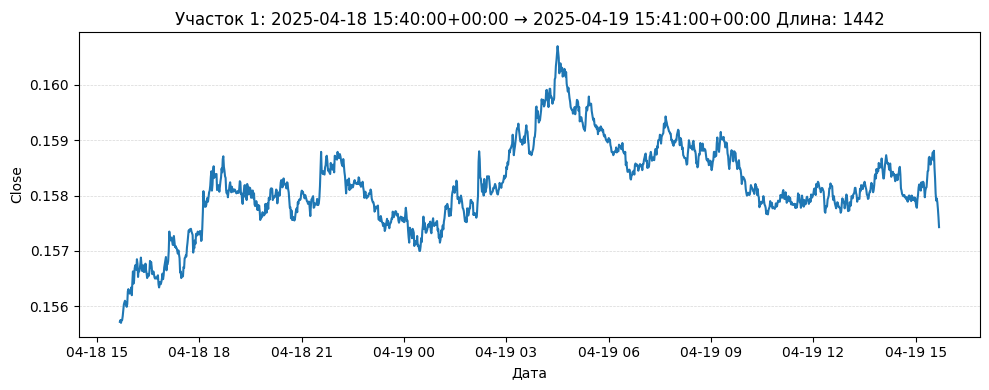

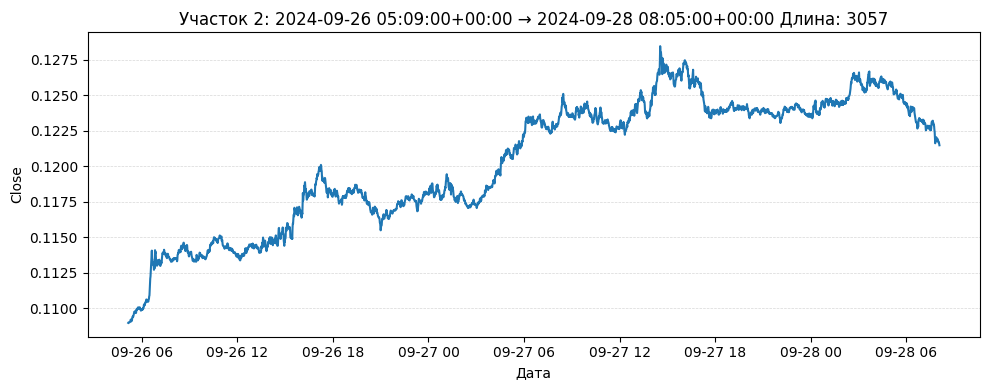

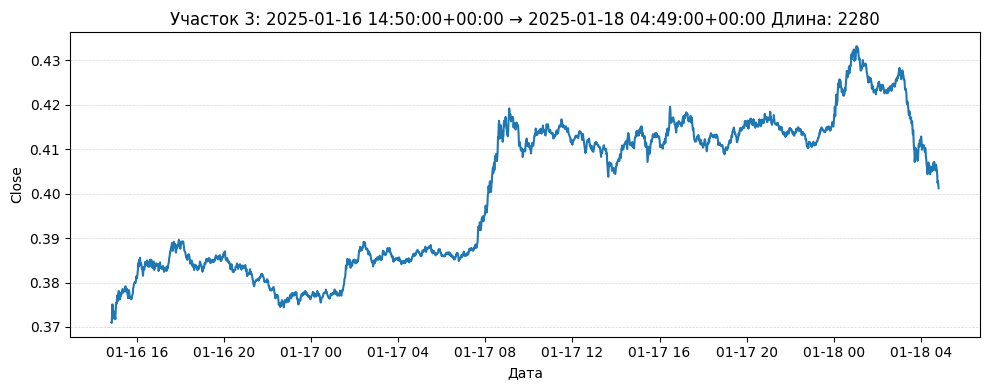

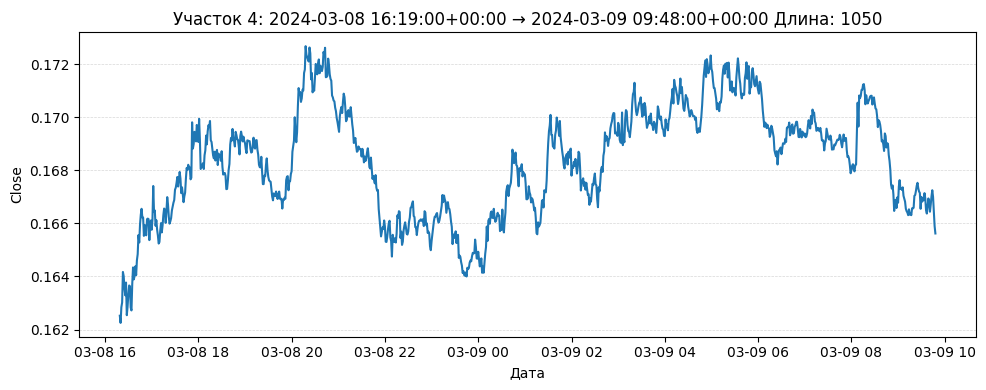

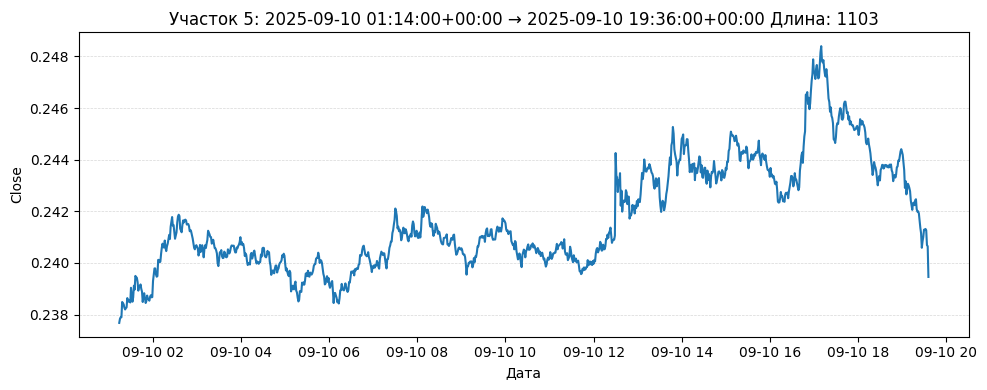

In [4]:
# @title Фильтрация датасета на трендовые участки

df['EMA_2500'] = ema_numba(close, 2500)

buy_sig  = (df['Close'] > df['EMA_2500'])
sell_sig = (df['Close'] < df['EMA_2500'])

df['Trend_filter'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

# 1) Получаем список участков
segments = get_intervals(df, 'Trend_filter', threshold=500)  # список DatetimeIndex

# 2) Рисуем 5 случайных участков
plot_price_with_valid(df, 'Close', segments, n_plots=5, seed=42, assume_df_tz='UTC')

In [ ]:
# @title Объяснение параметров и метрик
"""
PPO_UPDATES — количество крупных циклов обучения (policy updates). Каждый цикл включает:
- Сбор PPO_ROLLOUT шагов из PPO_N_ENV параллельных окружений.
- Разбиение собранных данных на мини-батчи PPO_BATCH_SIZE.
- PPO_EPOCHS проходов оптимизации по этим батчам.
Таким образом, общее число шагов взаимодействия со средой за весь запуск равно PPO_UPDATES × PPO_N_ENV × PPO_ROLLOUT.
На что влияет:
- Общее время и объём обучения. Большее значение → больше данных и gradient-обновлений → дольше тренировка, выше шанс достичь лучшей политики.
- Риск переобучения.При фиксированных данных каждая лишняя итерация может привести к “запоминанию” конкретных траекторий и ухудшению обобщающей способности.
- Использование вычислительных ресурсов. PPO_UPDATES напрямую задаёт количество итераций оптимизации, что определяет нагрузку на GPU/CPU.
Как подбирать:
- Базовая точка: 50 циклов — типичное стартовое значение для средних по сложности задач (≈1 млн шагов при 40 × 512 × 50).
- Если агент недоучивается (наградная кривая всё ещё растёт) — увеличьте параметр (например, до 100–200), чтобы дать модели больше времени на освоение среды.
- Если награда стабилизируется или падает до завершения обучения — уменьшайте PPO_UPDATES или используйте раннюю остановку по метрике валидации.
- Ориентир по шагам среды: выберите целевой объём взаимодействий (например, 2 млн шагов) и рассчитайте PPO_UPDATES = целевые_шаги / (PPO_N_ENV × PPO_ROLLOUT).
- Грамотная настройка PPO_UPDATES помогает балансировать между временем обучения, объёмом данных и качеством итоговой политики.


PPO_N_ENV - задаёт число окружений (environment instances), запускаемых одновременно. Каждый из них параллельно генерирует свои траектории взаимодействия с миром.
Зачем нужны несколько сред:
- Быстрая генерация данных. Одновременно работающие окружения собирают шаги опыта параллельно, что ускоряет обучение: за один и тот же реальный промежуток времени вы получаете PPO_N_ENV раз больше данных.
- Снижение корреляции. Последовательные шаги в одной среде сильно коррелированы. Запуск множества независимых эпизодов уменьшает зависимость между образцами, что делает оценку градиента более надёжной.
- Стабильное обучение. При большем разнообразии исходных состояний и траекторий политика быстрее покрывает пространство состояний, что помогает избежать локальных минимумов.
Как подбирать:
- Ограничения железа. Увеличение PPO_N_ENV потребляет больше CPU/GPU и памяти. Выбирайте значение, которое эффективно загружает доступные ресурсы (типично 8–64).
- Размер батча. Общее число шагов на одно обновление равно PPO_N_ENV × PPO_ROLLOUT. Если вам нужен крупный батч (например, для стабильности), проще увеличить PPO_N_ENV, чем сильно удлинять PPO_ROLLOUT.
- Время взаимодействия. Если среда медленная или взаимодействие дорогое, увеличивайте PPO_N_ENV, чтобы по максимуму распараллелить сбор данных.
- Когда уменьшать. Если компьютер не справляется (CPU загружен на 100%, задержки растут), снизьте число сред или используйте асинхронную схему (A3C, RLLib).
Правильное значение PPO_N_ENV — компромисс между скоростью обучения и доступными ресурсами; начинайте с числа, оптимально загружающего ваш сервер, и корректируйте в зависимости от стабильности и производительности обучения.


PPO_ROLLOUT - задаёт длину собранной траектории из каждого окружения перед одним обновлением политики.
Если PPO_N_ENV = 40 и PPO_ROLLOUT = 512, то за цикл обучения собирается 40 × 512 = 20 480 шагов взаимодействия.
На что влияет:
- Размер батча и скорость обновления. Длинный rollout увеличивает объём данных на обновление и реже вызывает оптимизацию, что делает каждое обновление более «массовым», но редким.
- Корреляция данных. Чем длиннее траектория, тем более последовательные (коррелированные) шаги попадают в выборку. Это может замедлить обучение,
особенно в задачах с высокой автокорреляцией.
- Обновление значений и преимущества. Rollout определяет глубину вычисления возвратов/GAE. Слишком короткий сегмент даёт «обрезанные» оценки,
а слишком длинный может приводить к устареванию данных, если политика за время сбора уже изменилась.
- Потребление памяти. Хранение длинных траекторий требует больше RAM/VRAM, что может ограничить максимальное значение на слабом оборудовании.
Как подбирать:
- Стартовое значение: 128–512 шагов — типичный диапазон для большинства задач в игре или управлении роботами.
- Баланс с PPO_N_ENV: поддерживайте общий размер батча (PPO_N_ENV × PPO_ROLLOUT) в разумных пределах (например, 8 000–30 000 шагов). Если увеличиваете число сред, rollout можно уменьшить.
- Если обучение шумное и нестабильное: попробуйте удлинить rollout, чтобы каждое обновление опиралось на большее количество данных.
- Если среда очень медленная: укорачивайте rollout и/или увеличивайте PPO_N_ENV, чтобы чаще обновлять политику и быстрее получать обратную связь.
- Анализ качества: отслеживайте кривые награды и скорость сходимости; оптимальное значение rollout — то, при котором прирост награды стабилен, а время до обновления не слишком велико.
Итог: PPO_ROLLOUT задаёт, сколько последовательных шагов собирает каждая среда до обновления. Он напрямую влияет на размер батча, корреляцию данных и частоту обновлений, поэтому выбирать его нужно в связке с количеством параллельных окружений и возможностями оборудования.


PPO_CLIP_RATIO — центральный гиперпараметр в алгоритме Proximal Policy Optimization. Его называют «шириной зажима» и обычно обозначают ε.
В PPO вычисляется отношение вероятностей действий новой политики и старой. Чтобы не позволять обновлённой политике слишком далеко «отклоняться» от старой, каждая величина
r(θ) проходит через функцию clip(r, 1-ε, 1+ε) и затем берётся минимум.
На что влияет:
- Стабильность обучения. Чем меньше PPO_CLIP_RATIO, тем более «осторожные» обновления: политика меняется медленно, но обучение устойчивее.
- Скорость и амплитуда обновлений.Больший параметр позволяет быстрее приспосабливаться к изменениям среды — но есть риск «разлета» градиентов и деградации.
- Баланс исследования/эксплуатации. При небольшом ε алгоритм дольше сохраняет свойства старой политики, что снижает риск забывания, но может замедлить улучшение.
Как подбирать:
- Стартовое значение: 0.1–0.3 (типичный базовый диапазон из статьи PPO).
- Если обучение нестабильно или награда сильно колеблется, уменьшите ε (например, 0.1 или 0.05).
- Если модель «залипает» и улучшается медленно, попробуйте увеличить (0.3 и выше), но контролируйте, чтобы потери и дивергенция не расходились.
- Иногда применяют адаптивную схему: отслеживают фактический KL-дивергенцию между старой и новой политиками и динамически корректируют PPO_CLIP_RATIO, но это усложняет реализацию.
Итого: PPO_CLIP_RATIO — это безопасный «коридор», внутри которого политика может двигаться за один шаг обновления. Правильная настройка этого параметра критична для того, чтобы обучение было и стабильным, и достаточно быстрым.


PPO_MAX_GRAD_NORM - задаёт верхнее ограничение на норму (длину) вектора градиента при обновлении параметров сети.
После вычисления градиентов они при необходимости «обрезаются» так, чтобы их норма не превышала это значение.
На что влияет:
- Стабильность обучения. Ограничение градиентов предотвращает резкие скачки параметров и защищает от взрывных градиентов, особенно при высокой скорости обучения.
- Сходимость. При корректном «клиппинге» градиента модель движется к минимуму более плавно, что способствует более надёжной сходимости.
- Скорость обучения. Слишком низкий порог может замедлить адаптацию, поскольку сильные градиенты будут «срезаться», а слишком высокий — не окажет должной стабилизации.
Как подбирать:
- Стартовое значение: 0.5–1.0 — типичный диапазон для большинства задач с PPO.
- Если наблюдаются взрывы градиента (loss резко скачет, параметры становятся nan), уменьшите значение.
- Если обучение идёт слишком медленно и градиенты редко достигают порога, можно слегка увеличить PPO_MAX_GRAD_NORM.
- Комбинируйте с learning rate: при повышении PPO_ACTOR_LR или PPO_CRITIC_LR может потребоваться более жёсткое ограничение градиента.
Итого: PPO_MAX_GRAD_NORM — «страховочный трос» для градиентов, удерживающий шаги оптимизации в разумных пределах.
Его грамотная настройка помогает избежать нестабильности и сохранить баланс между скоростью и надёжностью обучения.


PPO_TARGET_KL — целевое значение KL-дивергенции между старой и новой политиками. После каждого обновления алгоритм измеряет фактическую KL-дивергенцию и сравнивает её с целевым порогом.
На что влияет:
- Контроль шага обновления. Если реальная дивергенция превышает PPO_TARGET_KL, дальнейшие итерации оптимизации останавливаются или замедляются — это предотвращает слишком резкие изменения политики.
- Стабильность обучения. Поддержание дивергенции вблизи целевого значения способствует более плавной и предсказуемой траектории обучения.
- Компромисс между скоростью и надёжностью. Более низкий порог делает обучение осторожным, но может замедлить прогресс; более высокий — ускоряет адаптацию, но повышает риск нестабильности.
Как подбирать:
- Стартовое значение: 0.01 — распространённый базовый выбор.
- Если наблюдается «разлёт» политики (потери нестабильны, награда скачет), попробуйте уменьшить PPO_TARGET_KL, чтобы жёстче контролировать изменения.
- Если обучение идёт слишком медленно и KL практически не достигает порога, значение можно поднять (например, до 0.02–0.05), позволяя большей свободе обновлений.
- Адаптивные схемы: иногда вводят постепенное снижение порога по ходу обучения, чтобы сначала быстро исследовать, а потом стабилизироваться.
Итого: PPO_TARGET_KL служит «стоп-сигналом» для слишком больших отклонений новой политики от старой.
Правильно подобранный порог помогает сочетать быстрое обучение с контролируемой стабильностью, что особенно важно при длительных или чувствительных к разрывам задачах.


PPO_GAMMA (discount factor) — коэффициент дисконтирования будущих вознаграждений.
Значение ближе к 1 делает агент более «дальнозорким», учитывая долгосрочные последствия действий.
Более низкое значение заставляет агента концентрироваться на ближайшем вознаграждении.
Типичные значения: 0.99, 0.95 — выбираются в зависимости от глубины временного горизонта задачи.


PPO_LAM (lambda) — параметр обобщённой оценки преимущества (GAE), регулирующий баланс между bias и variance.
Значение 1.0 приводит к меньшему смещению, но более высокому разбросу.
Значение 0.0 повышает смещение, но уменьшает разброс, что делает обучение более «шумным».
Часто используется 0.95–0.97, но оптимальное значение зависит от особенностей среды и политики.
Практика подбора:
- Начать с общепринятых значений (gamma=0.99, lam=0.95).
- Выполнить поиск по сетке (grid search) или использованию систематических экспериментов, меняя по одному параметру.
- Анализировать метрики обучения (скорость сходимости, стабильность, итоговое качество политики) и при необходимости корректировать параметры.

****
МЕТРИКИ:

policy_loss = -0.01140
Отражает, насколько сильно обновление политики снижает целевую функцию. Небольшое отрицательное значение говорит о том,
что текущие обновления улучшают политику, но шаги достаточно осторожные. Если абсолютное значение постоянно растёт (становится более отрицательным),
модель активно адаптируется; если стремится к нулю — политика стабилизируется.

value_loss = 0.72330
Показывает ошибку критика при оценке ожидаемого вознаграждения. Чем меньше, тем точнее предсказания.
Значение выше ~0.7 может означать, что критик ещё не до конца обучен или задача сложная.
Если loss со временем снижается — критик становится точнее; рост может указывать на переобучение политики или слишком высокую скорость обучения критика.

entropy = 0.43223
Измеряет “случайность” действий (степень исследования). 0.43 — умеренная энтропия: политика сохраняет разнообразие, но уже не совершенно случайна.
По мере обучения энтропия обычно убывает: слишком быстрое падение — риск преждевременной детерминированности, слишком медленное — модель долго остаётся хаотичной.

approx_kl = 0.05351
Приблизительная KL-дивергенция между старой и новой политиками. Она показывает, насколько сильно изменяется политика после обновления.
Значение 0.0535 в пять раз превышает ваш целевой PPO_TARGET_KL = 0.01, что может сигнализировать о слишком резких шагах.
Если approx_kl стабильно выше порога, стоит уменьшить PPO_CLIP_RATIO или скорость обучения.

teacher_kl = 0.0457
Среднее значение KL-дивергенции между текущей политикой и teacher‑моделью. В коде собранные на каждой итерации t_kl складываются в список teacher_kls, а затем усредняются.
Значение ~0.046 говорит, что политика умеренно отклоняется от teacher: выше нуля (политика учится отличаться), но далеко от заданного лимита 0.1.

clip_fraction = 0.0124
Доля шагов, где отношение вероятностей действий вышло за пределы 1 ± PPO_CLIP_RATIO и была применена обрезка.
В коде эти события накапливаются в clipfracs, после чего берётся их среднее. Низкое значение (~1.2 %) означает,
что обновления оставались в пределах допустимого коридора, и политика изменялась достаточно плавно.

avg_return = -0.1172
Среднее возвращённое вознаграждение по собранной траектории за обновление.
В коде вычисляется как среднее значение traj.returns и записывается в метрики.
Отрицательная величина показывает, что агент в среднем пока приносит убыток — требуется дальнейшее обучение или настройка гиперпараметров.

Что означают изменения во времени
Падение policy_loss и value_loss — признак прогресса, но отслеживайте, чтобы value_loss не рос после изначального падения.
Снижение энтропии — нормальный процесс, но важно, чтобы она не опускалась слишком рано; в противном случае увеличьте PPO_C2.
Пики approx_kl выше целевого порога — сигнал, что обновления могут быть слишком агрессивными;
при регулярном превышении значения следует уменьшить PPO_ACTOR_LR, PPO_CLIP_RATIO или число эпох PPO_EPOCHS.


****
Как интерпретировать тренировочные метрики после апдейта PPO

Понимание масштаба наград. Шаговое вознаграждение формируется как pnl_step + penalty (штрафы за удержание и простои учитываются симметрично),
после чего умножается на cfg.reward_scale; именно это число и записывается в траектории.
Повышение масштаба делает все положительные и отрицательные сигналы пропорционально крупнее.

Что именно печатается после Update=N. Внутри цикла train для каждого апдейта сначала выполняется ppo_update, затем к возвращённому словарю метрик
добавляются агрегаты по возвратам, преимуществам и текущий коэффициент энтропии; при debug=True печать начинается со строки KL_teacher: ...,
после чего выводится весь словарь metrics из train_log.
Важно: KL_teacher в логе — это обновлённый коэффициент перед KL-штрафом, который будет применён на следующем апдейте;
сама средняя дивергенция хранится в поле teacher_kl внутри metrics.

Метрики актёра (качество политики):
policy_loss — среднее значение функции PPO с клиппингом; преимущества перед вычислением нормализуются до нулевого среднего и единичного СКО,
поэтому шкала лосса удерживается порядка единицы и напрямую сопоставима с регуляризаторами.
entropy — средняя энтропия по допустимым действиям; помогает оценивать степень стохастичности политики.
teacher_kl — средняя KL-дивергенция между текущей политикой и учителем; рост указывает на расхождение с учителем, что может потребовать
ручного увеличения/уменьшения kl_coef или проверки, не доминирует ли штраф.
approx_kl — приближённая дивергенция между новой и старой политикой; если стабильно превышает целевой порог, это сигнал о слишком агрессивных шагах обновления.
clip_fraction — доля сэмплов, для которых отношение вероятностей вышло за границы клипа; рост сверх 0.1–0.2 обычно сигнализирует о сильных сдвигах и
риске дестабилизации обучения.

Метрики критика:
value_loss — MSE между возвратами и предсказанием критика;
value_rmse и value_mae — корень из MSE и средняя абсолютная ошибка, добавленные для интерпретации в тех же единицах, что и returns.
Эти значения стоит сопоставлять с returns_std/returns_mean_abs, чтобы понять, насколько baseline точен по сравнению с типичным масштабом целевого сигнала.

Диагностика возвратов и преимуществ:
avg_return, returns_std, returns_mean_abs характеризуют распределение целевых возвратов;
резкий рост при неизменном value_rmse указывает на то, что критик не догоняет масштаб наград.
adv_mean, adv_std, adv_mean_abs вычисляются по «сырым» преимуществам до нормализации;
если среднее сильно отрицательно или стандартное отклонение растёт, это признак смещения baseline или накопления штрафов задолго до их начисления
(диагностируйте и корректируйте reward_scale, valid_time, штрафы).

Регуляризационные коэффициенты:
entropy_coef — фактическое значение коэффициента перед энтропийным бонусом, применённое на текущем апдейте;
оно может затухать со временем и влияет на баланс policy_loss против энтропийного слагаемого.
KL_teacher (в заголовке) позволяет понять, насколько сильным будет штраф к учителю в следующей эпохе;
сочетайте его с фактической teacher_kl, чтобы оценить, не перетягивает ли регуляризация обновления актёра.
Связка с reward_scale. Поскольку награды пропорциональны reward_scale, а преимущества перед оптимизацией нормализуются,
сам policy_loss по величине остаётся в диапазоне O(1); однако распределение знаков преимуществ и средних возвратов меняется, что отражается в adv_mean и returns_*.
Если увеличение reward_scale ведёт к редким сделкам, отслеживайте уменьшение adv_mean/рост adv_mean_abs и сравнивайте value_rmse с returns_mean_abs, чтобы убедиться,
что критик успевает адаптироваться.

"""

In [5]:
# @title Обучение на весах SL модели
SL_MODEL_CONFIG = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/soft_labels_exp1/config.joblib"
PPO_SAVE_PATH = '/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_results/soft_labels_exp1'
CONFIG = joblib.load(SL_MODEL_CONFIG)

SPLITS = (0.70, 0.15, 0.15)
BEST_MODEL_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/soft_labels_exp1/best_full_model_ep:18_f1:63.3.weights.h5"
BEST_BACKBONE_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/soft_labels_exp1/best_backbone__ep:18_f1:63.3.weights.h5"
BEST_CRITIC_PATH = "" # нет потому что в SL мы не учим критика, вместо этого берем backbone
FEATURES = CONFIG['features']
ACCOUNT_F = CONFIG['state']

# @title PPO training parameters
PPO_SEQ_LEN = CONFIG['seq_len'] # ширина окна (такая же как при обучении SL)
PPO_FEATURES_DIM = len(FEATURES) + len(ACCOUNT_F)
PPO_NUM_ACTIONS = CONFIG['num_actions'] # кол-во возможных действий (такое же как при обучении SL)
PPO_UNITS = CONFIG['units'] #  кол-во нейронов (такое же как при обучении SL)
PPO_DROPOUT = CONFIG['dropout']

# PPO params
PPO_UPDATES = 100         # число обновлений политики за цикл обучения (эпохи)
PPO_N_ENV = 200        # количество параллельных окружений для сбора данных
PPO_N_VAL = 2           # кол-во валидаций на один update
PPO_ROLLOUT = 1024       # длина траектории (количество шагов), собираемой перед обновлением
PPO_ACTOR_LR = 1e-3     # скорость обучения актёра
PPO_CRITIC_LR = 3e-4    # скорость обучения критика
PPO_CLIP_RATIO = 0.2    # центральный гиперпараметр в алгоритме Proximal Policy Optimization. Его называют «шириной зажима»
PPO_C1 = 0.5            # коэффициент перед вкладом ошибки критика в функции потерь
PPO_C2 = 0.02       # коэффициент перед бонусом энтропии в функции потерь (чем больше, тем больше эксплорейшн)
PPO_GAMMA = 0.99      # (discount factor) — коэффициент дисконтирования будущих вознаграждений.
PPO_LAM = 0.95          # параметр обобщённой оценки преимущества (GAE), регулирующий баланс между bias и variance.
PPO_EPOCHS = 10         # количество проходов по батчу при обучении
PPO_BATCH_SIZE = 128    # размер мини-батча для SGD
PPO_TEACHER_KL = 0.1   # начальный вес KL‑регуляризации с teacher‑моделью
PPO_KL_DECAY = 0.99      # коэффициент экспоненциального затухания веса KL
PPO_ENTROPY_DECAY = 0.99 # коэффициент экспоненциального затухания веса entropy
PPO_TARGET_KL = 0.03    # целевое значение KL‑дивергенции для ранней остановки
PPO_MAX_GRAD_NORM = 0.5 # ограничение нормы градиента для стабилизации обучения
PPO_VAL_INTERVAL = 2    # периодичность валидации (через сколько циклов обучения)
PPO_DEBUG = True        # режим вывода отладочной информации
PPO_DEALS_FREQ = 0.10    # допустимое кол-во сделок модели относительно учителя

# INDEXES = [("2024-05-01", 1000), ("2024-07-01", 500)] # если хочешь учить на конкретных отрезках данных

# Подготавливаем данные и вычисляем статистики нормализации
ppo_train_df, ppo_val_df, ppo_test_df, _feat_stats = prepare_datasets(df,
                                                                      FEATURES,
                                                                      splits=SPLITS,
                                                                      norm_kind='minmax')


TRAIN_CFG = EnvConfig(
    mode=1,                         # работаем только от длинной позиции
    fee=0.0005,                     # комиссия
    spread=0.0,                     # без спреда
    leverage=1.0,                   # без плеча
    max_steps=PPO_ROLLOUT + PPO_SEQ_LEN,
    reward_scale=10.0,              # без масштабирования вознаграждения
    valid_time=120,                 # задержка после которой начинат начисляться штраф
    time_penalty=0.00005,           # штраф за бездействие (np.sqrt(max(0, wait_steps -5) * time_penalty))
    hold_penalty=0.00005,           # штраф за удержание (np.sqrt(max(0, hold_steps -5) * hold_penalty))
    terminal_reward = True,         # дополнительная награда по закрытию сделки
    terminal_reward_coef = 2.0,     # коэффициент доп. награды
    close_deal_if_done = False,     # закрытие сделки в конце эпизода
    only_positive_tr_reward = True  # только положительная терминальная награда
)

VAL_CFG = EnvConfig(
    mode=1,                         # работаем только от длинной позиции
    fee=0.0005,                     # комиссия
    spread=0.0,                     # без спреда
    leverage=1.0,                   # без плеча
    max_steps=1e9,
    reward_scale=10.0,              # без масштабирования вознаграждения
    valid_time=120,                 # задержка после которой начинат начисляться штраф
    time_penalty=0.00005,           # штраф за бездействие (np.sqrt(max(0, wait_steps -5) * time_penalty))
    hold_penalty=0.00005,           # штраф за удержание (np.sqrt(max(0, hold_steps -5) * hold_penalty))
    terminal_reward = True,         # дополнительная награда по закрытию сделки
    terminal_reward_coef = 2.0,     # коэффициент доп. награды
    close_deal_if_done = False,     # закрытие сделки в конце эпизода
    only_positive_tr_reward = True  # только положительная терминальная награда
)

actor, critic, train_log, val_log = train(
    ppo_train_df,
    ppo_val_df,
    TRAIN_CFG,
    VAL_CFG,
    PPO_FEATURES_DIM,
    FEATURES,
    seq_len = PPO_SEQ_LEN,
    teacher_weights = BEST_MODEL_PATH,
    critic_weights = BEST_CRITIC_PATH,
    backbone_weights = BEST_BACKBONE_PATH,
    save_path = PPO_SAVE_PATH,
    num_actions = PPO_NUM_ACTIONS,
    units = PPO_UNITS,
    dropout = PPO_DROPOUT,
    updates = PPO_UPDATES,
    n_env = PPO_N_ENV,
    n_validations = PPO_N_VAL,
    deals_frequency = PPO_DEALS_FREQ,
    rollout = PPO_ROLLOUT,
    actor_lr = PPO_ACTOR_LR,
    critic_lr = PPO_CRITIC_LR,
    clip_ratio = PPO_CLIP_RATIO,
    c1 = PPO_C1,
    c2 = PPO_C2,
    gamma = PPO_GAMMA,
    lam = PPO_LAM,
    epochs = PPO_EPOCHS,
    batch_size = PPO_BATCH_SIZE,
    teacher_kl = PPO_TEACHER_KL,
    kl_decay = PPO_KL_DECAY,
    entropy_decay = PPO_ENTROPY_DECAY,
    max_grad_norm = PPO_MAX_GRAD_NORM,
    target_kl = PPO_TARGET_KL,
    val_interval = PPO_VAL_INTERVAL,
    index_ranges = segments,
    debug = PPO_DEBUG,
    log_to_pdf_path=True
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Fine tuning

# Параметры
SL_MODEL_CONFIG = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/config.joblib"
PPO_SAVE_PATH = '/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/ft'
CONFIG = joblib.load(SL_MODEL_CONFIG)

SPLITS = (0.80, 0.10, 0.1)
BEST_PATH_ACTOR = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp1/actor_best_ep:2_rt:0.2314.weights.h5"
BEST_CRITIC_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp1/critic_best_ep:2_rt0.2314.weights.h5"
BEST_BACKBONE_PATH = ""
FEATURES = CONFIG['features']
ACCOUNT_F = CONFIG['state']

# @title PPO training parameters
PPO_SEQ_LEN = CONFIG['seq_len'] # ширина окна (такая же как при обучении SL)
PPO_FEATURES_DIM = len(FEATURES) + len(ACCOUNT_F)
PPO_NUM_ACTIONS = CONFIG['num_actions'] # кол-во возможных действий (такое же как при обучении SL)
PPO_UNITS_PER_LAYER = CONFIG['units_per_layer'] #  кол-во нейронов (такое же как при обучении SL)
PPO_DROPOUT = CONFIG['dropout']

# INDEXES = [("2024-05-01", 1000), ("2024-07-01", 500)]

# PPO training parameters
PPO_UPDATES = 4
PPO_N_ENV = 80
PPO_ROLLOUT = 256
PPO_ACTOR_LR = 3e-3
PPO_CRITIC_LR = 1e-3
PPO_CLIP_RATIO = 1.5
PPO_C1 = 0.5
PPO_C2 = 0.02
PPO_EPOCHS = 10
PPO_BATCH_SIZE = 64
PPO_TEACHER_KL = 0.05
PPO_KL_DECAY = 0.5
PPO_TARGET_KL = 0.001
PPO_MAX_GRAD_NORM = 0.5
PPO_VAL_INTERVAL = 1
PPO_DEBUG = True
PPO_FUNE_TUNE = True

TRAIN_CFG = EnvConfig(
    mode=1,                     # работаем только от длинной позиции
    fee=0.0002,                 # комиссия
    spread=0.0001,              # без спреда
    leverage=1.0,               # без плеча
    max_steps=10**9,            # практически бесконечный эпизод
    reward_scale=1.0,           # без масштабирования вознаграждения
    valid_time=10,              # задержка после которой начинат начисляться штраф
    time_penalty=0.000001,      # штраф за бездействие (np.sqrt(max(0, wait_steps -5) * time_penalty))
    hold_penalty=0.000001,      # штраф за удержание (np.sqrt(max(0, hold_steps -5) * hold_penalty))
    terminal_reward = False,    # дополнительная награда по закрытию сделки
    terminal_reward_coef = 0.0, # коэффициент доп. награды
)

VAL_CFG = EnvConfig(
    mode=1,                     # работаем только от длинной позиции
    fee=0.0002,                 # комиссия
    spread=0.0001,              # без спреда
    leverage=1.0,               # без плеча
    max_steps=10**9,            # практически бесконечный эпизод
    reward_scale=1.0,           # без масштабирования вознаграждения
    valid_time=10,              # задержка после которой начинат начисляться штраф
    time_penalty=0.000001,      # штраф за бездействие (np.sqrt(max(0, wait_steps -5) * time_penalty))
    hold_penalty=0.000001,      # штраф за удержание (np.sqrt(max(0, hold_steps -5) * hold_penalty))
    terminal_reward = False,    # дополнительная награда по закрытию сделки
    terminal_reward_coef = 0.0, # коэффициент доп. награды
)

actor, critic, train_log, val_log = train(
    ppo_train_df,
    ppo_val_df,
    TRAIN_CFG,
    VAL_CFG,
    PPO_FEATURES_DIM,
    FEATURES,
    seq_len = PPO_SEQ_LEN,
    teacher_weights = BEST_PATH_ACTOR,
    critic_weights = BEST_CRITIC_PATH,
    backbone_weights = BEST_BACKBONE_PATH,
    save_path = PPO_SAVE_PATH,
    num_actions = PPO_NUM_ACTIONS,
    units = PPO_UNITS_PER_LAYER,
    dropout = PPO_DROPOUT,
    updates = PPO_UPDATES,
    n_env = PPO_N_ENV,
    rollout = PPO_ROLLOUT,
    actor_lr = PPO_ACTOR_LR,
    critic_lr = PPO_CRITIC_LR,
    clip_ratio = PPO_CLIP_RATIO,
    c1 = PPO_C1,
    c2 = PPO_C2,
    epochs = PPO_EPOCHS,
    batch_size = PPO_BATCH_SIZE,
    teacher_kl = PPO_TEACHER_KL,
    kl_decay = PPO_KL_DECAY,
    max_grad_norm = PPO_MAX_GRAD_NORM,
    target_kl = PPO_TARGET_KL,
    val_interval = PPO_VAL_INTERVAL,
    # index_ranges = INDEXES,
    debug = PPO_DEBUG,
    fine_tune = PPO_FUNE_TUNE
)

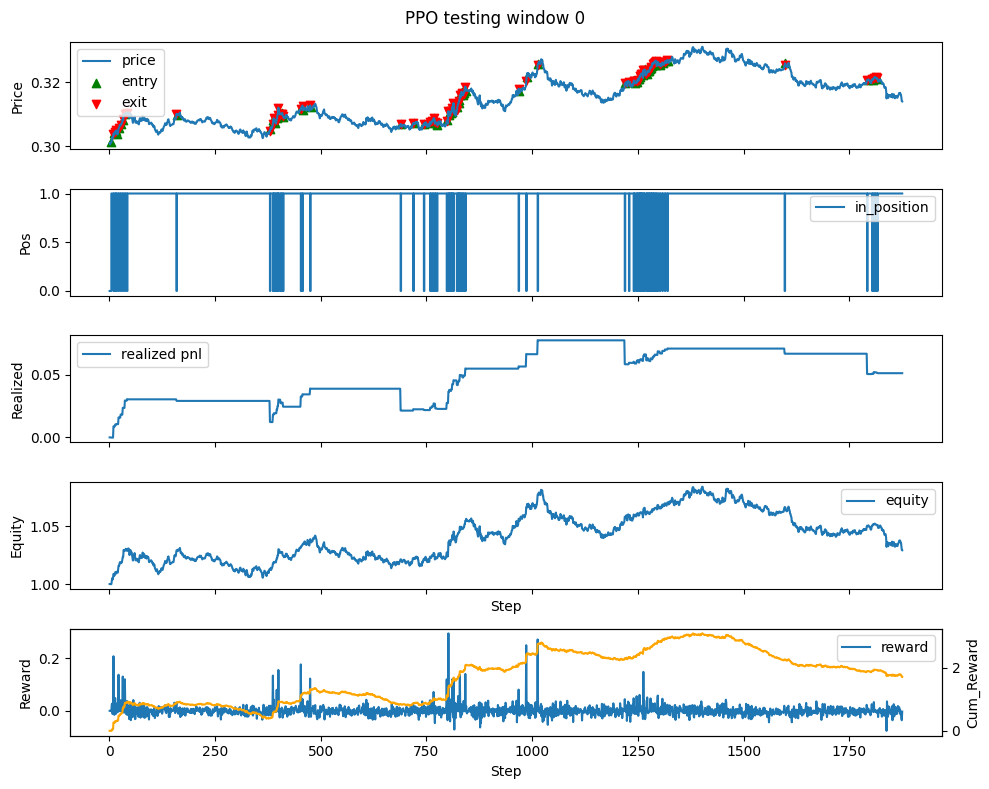


Metrics Report (window 0)
Annual Return: 8.2164
Average Win/Loss Ratio: 0.6641
Avg PnL per trade: 0.0009
Calmar Ratio: 162.0716
Closed trades: 82.0000
Equity: 0.0293
Maximum Drawdown: 0.0507
Profit Factor: 1.7810
Realized PnL: 0.0511
Recovery Factor: 0.5779
Sharpe Ratio: 7.6698
Sortino Ratio: 11.9697
Time Under Water: 0.9664
Value at Risk: 0.0024
Win Rate: 71.9512


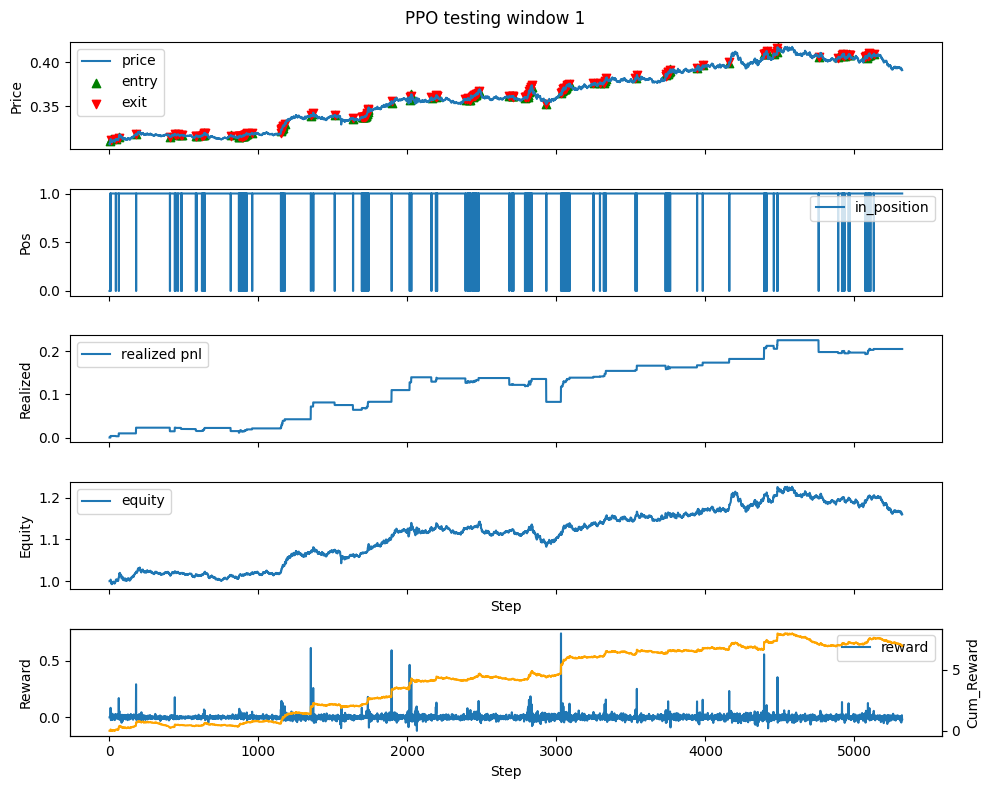


Metrics Report (window 1)
Annual Return: 15.8353
Average Win/Loss Ratio: 0.9760
Avg PnL per trade: 0.0016
Calmar Ratio: 292.9601
Closed trades: 163.0000
Equity: 0.1603
Maximum Drawdown: 0.0541
Profit Factor: 2.2309
Realized PnL: 0.2050
Recovery Factor: 2.9653
Sharpe Ratio: 13.4559
Sortino Ratio: 19.3383
Time Under Water: 0.9718
Value at Risk: 0.0025
Win Rate: 68.7117


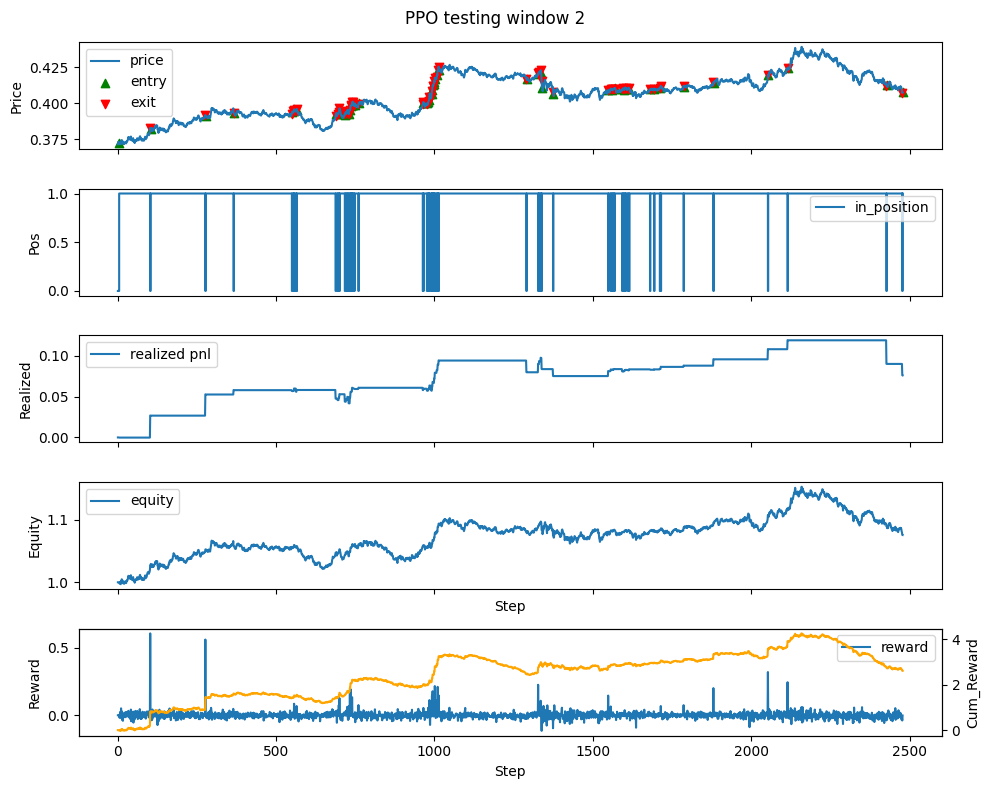


Metrics Report (window 2)
Annual Return: 16.1108
Average Win/Loss Ratio: 0.8129
Avg PnL per trade: 0.0016
Calmar Ratio: 240.0208
Closed trades: 65.0000
Equity: 0.0759
Maximum Drawdown: 0.0671
Profit Factor: 1.8290
Realized PnL: 0.0759
Recovery Factor: 1.1307
Sharpe Ratio: 11.4120
Sortino Ratio: 16.8789
Time Under Water: 0.9649
Value at Risk: 0.0031
Win Rate: 69.2308


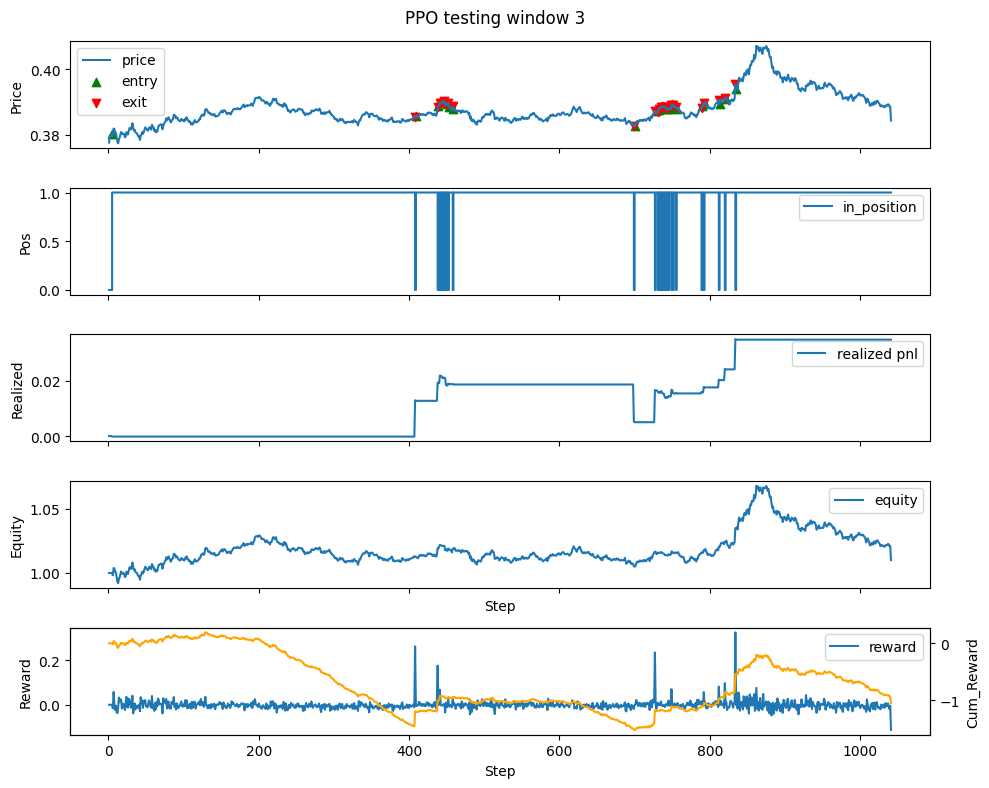


Metrics Report (window 3)
Annual Return: 5.1016
Average Win/Loss Ratio: 1.3248
Avg PnL per trade: 0.0018
Calmar Ratio: 94.0250
Closed trades: 25.0000
Equity: 0.0101
Maximum Drawdown: 0.0543
Profit Factor: 3.4067
Realized PnL: 0.0349
Recovery Factor: 0.1860
Sharpe Ratio: 4.9006
Sortino Ratio: 7.3119
Time Under Water: 0.9549
Value at Risk: 0.0021
Win Rate: 72.0000


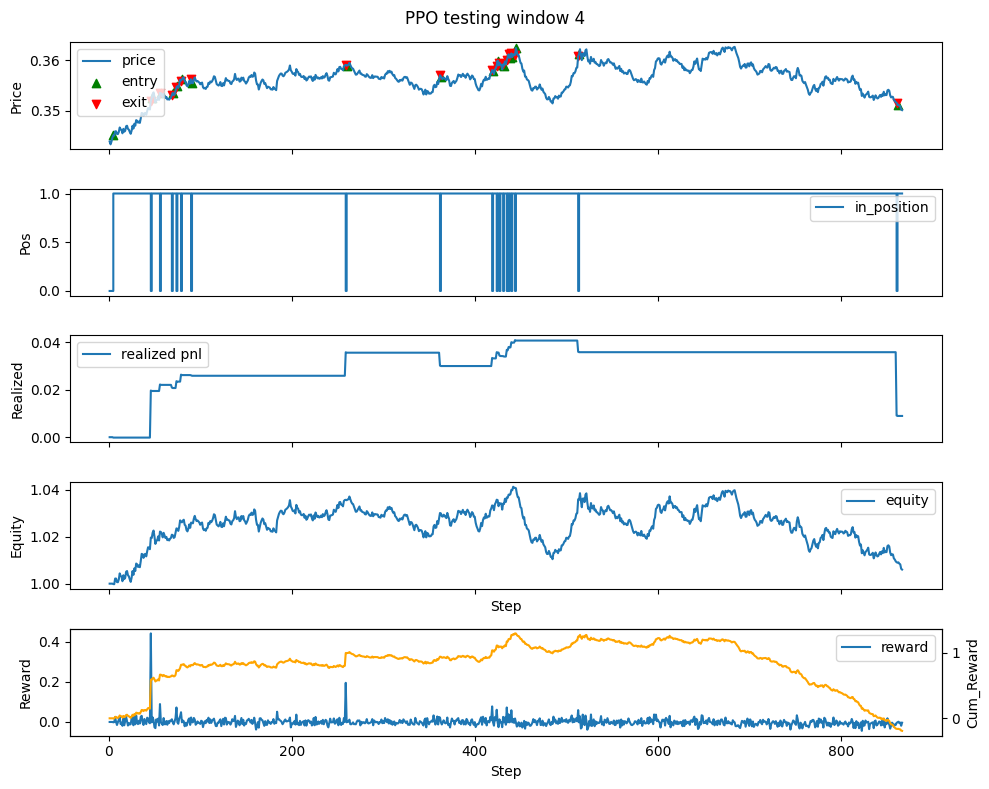


Metrics Report (window 4)
Annual Return: 3.6401
Average Win/Loss Ratio: 0.5406
Avg PnL per trade: 0.0009
Calmar Ratio: 107.4813
Closed trades: 18.0000
Equity: 0.0060
Maximum Drawdown: 0.0339
Profit Factor: 1.4055
Realized PnL: 0.0089
Recovery Factor: 0.1771
Sharpe Ratio: 3.6478
Sortino Ratio: 6.4374
Time Under Water: 0.9504
Value at Risk: 0.0021
Win Rate: 72.2222


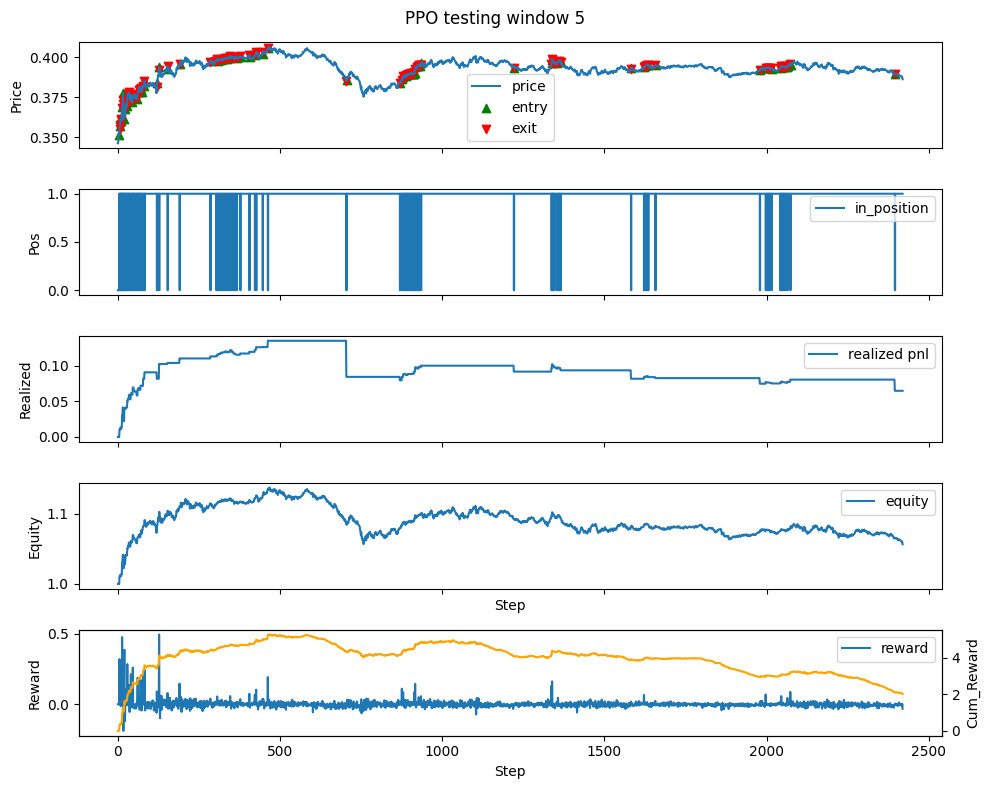


Metrics Report (window 5)
Annual Return: 12.2706
Average Win/Loss Ratio: 0.8559
Avg PnL per trade: 0.0010
Calmar Ratio: 172.5016
Closed trades: 103.0000
Equity: 0.0565
Maximum Drawdown: 0.0711
Profit Factor: 1.6383
Realized PnL: 0.0648
Recovery Factor: 0.7936
Sharpe Ratio: 10.4370
Sortino Ratio: 14.8367
Time Under Water: 0.9781
Value at Risk: 0.0022
Win Rate: 65.0485


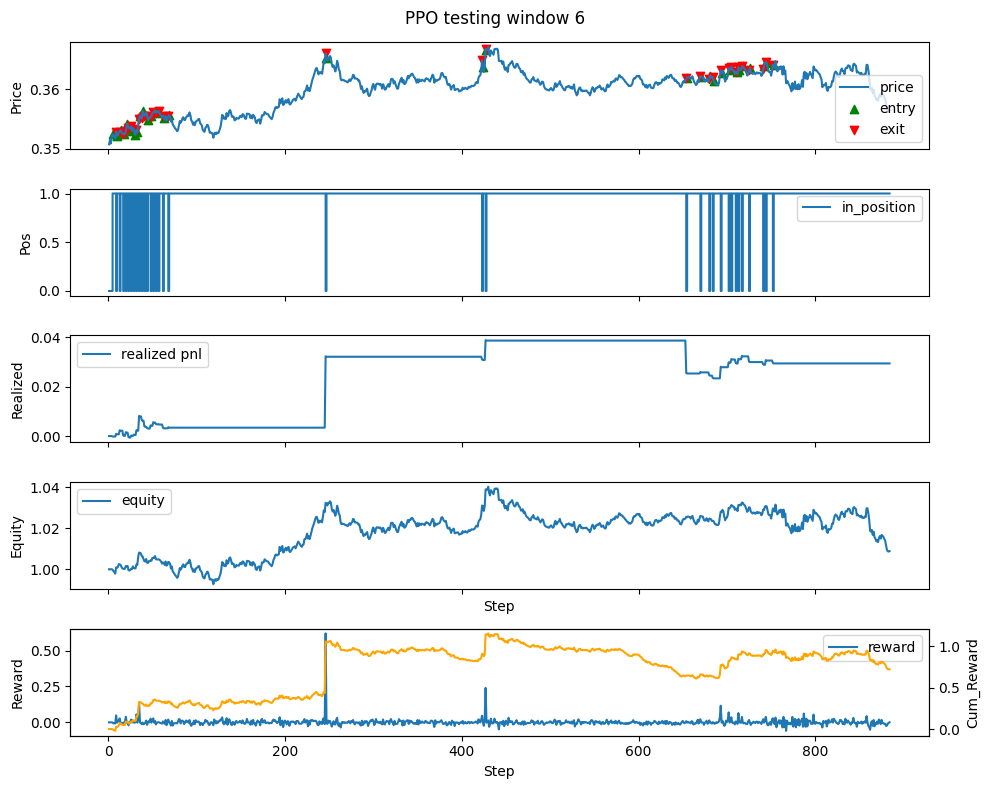


Metrics Report (window 6)
Annual Return: 5.2465
Average Win/Loss Ratio: 1.8346
Avg PnL per trade: 0.0012
Calmar Ratio: 173.1069
Closed trades: 35.0000
Equity: 0.0088
Maximum Drawdown: 0.0303
Profit Factor: 2.4461
Realized PnL: 0.0294
Recovery Factor: 0.2908
Sharpe Ratio: 5.4617
Sortino Ratio: 8.5510
Time Under Water: 0.9638
Value at Risk: 0.0020
Win Rate: 57.1429


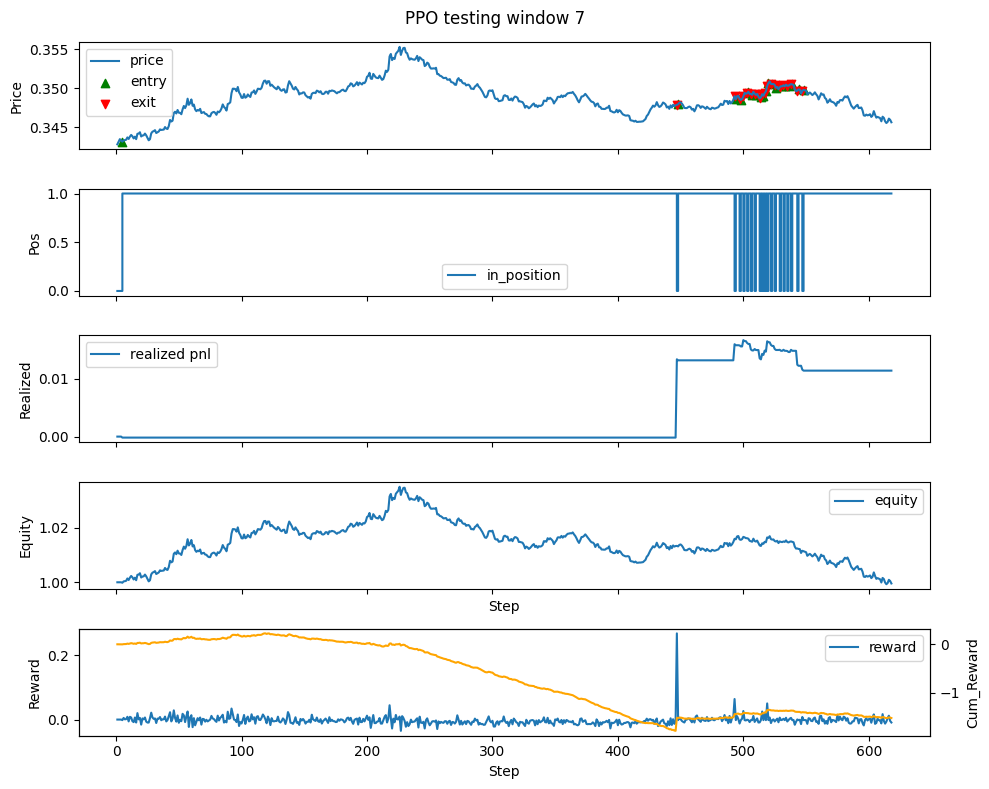


Metrics Report (window 7)
Annual Return: -0.3684
Average Win/Loss Ratio: 2.5050
Avg PnL per trade: 0.0010
Calmar Ratio: -10.6491
Closed trades: 19.0000
Equity: -0.0004
Maximum Drawdown: 0.0346
Profit Factor: 4.2943
Realized PnL: 0.0114
Recovery Factor: -0.0125
Sharpe Ratio: -0.5972
Sortino Ratio: -1.0003
Time Under Water: 0.9272
Value at Risk: 0.0013
Win Rate: 63.1579


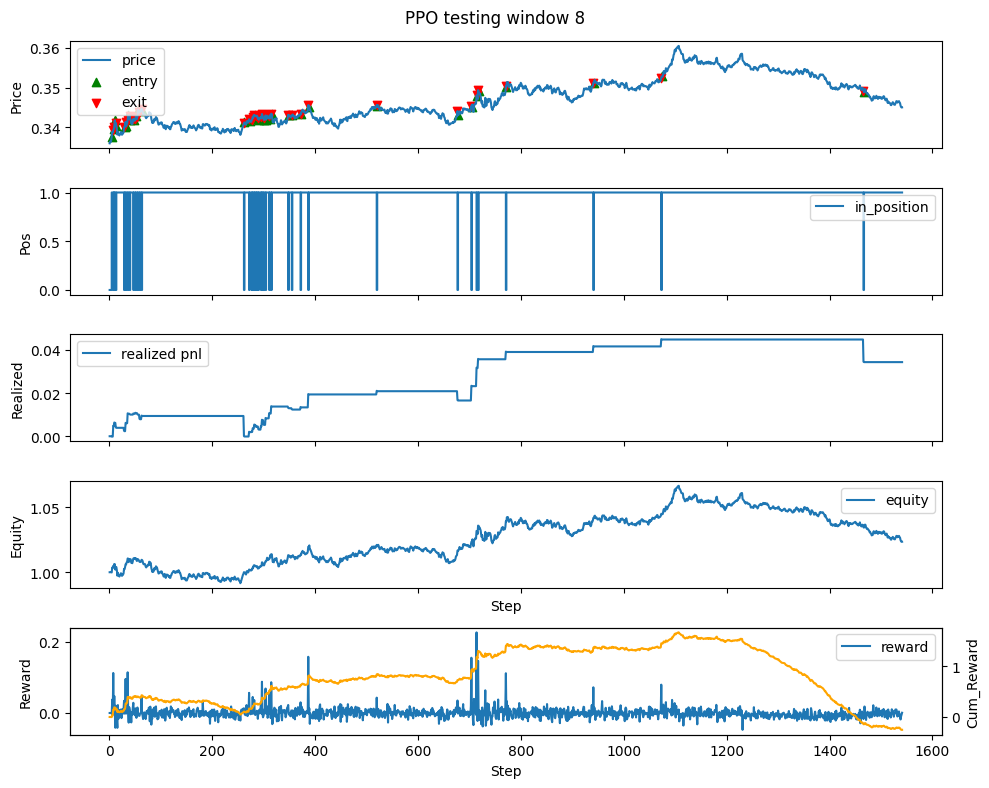


Metrics Report (window 8)
Annual Return: 8.0149
Average Win/Loss Ratio: 1.2293
Avg PnL per trade: 0.0012
Calmar Ratio: 197.9834
Closed trades: 39.0000
Equity: 0.0235
Maximum Drawdown: 0.0405
Profit Factor: 2.4586
Realized PnL: 0.0344
Recovery Factor: 0.5801
Sharpe Ratio: 9.8165
Sortino Ratio: 15.8737
Time Under Water: 0.9624
Value at Risk: 0.0017
Win Rate: 66.6667


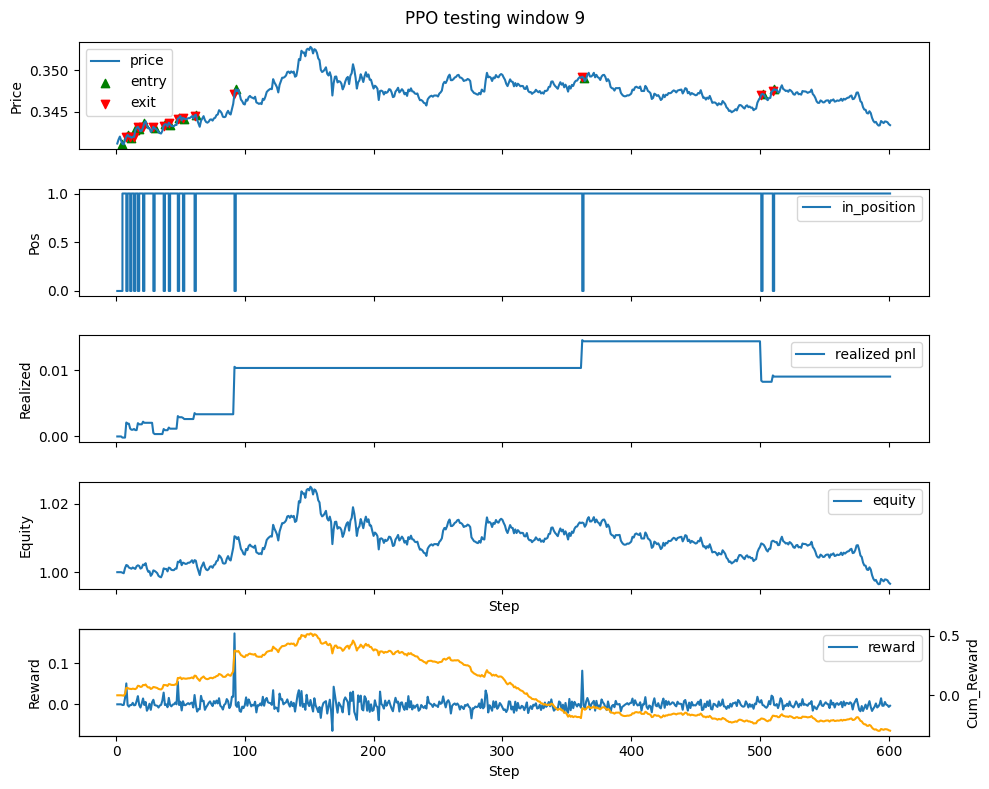


Metrics Report (window 9)
Annual Return: -2.9614
Average Win/Loss Ratio: 0.7172
Avg PnL per trade: 0.0010
Calmar Ratio: -106.5001
Closed trades: 15.0000
Equity: -0.0034
Maximum Drawdown: 0.0278
Profit Factor: 2.8689
Realized PnL: 0.0090
Recovery Factor: -0.1216
Sharpe Ratio: -3.8891
Sortino Ratio: -5.7883
Time Under Water: 0.9517
Value at Risk: 0.0016
Win Rate: 80.0000


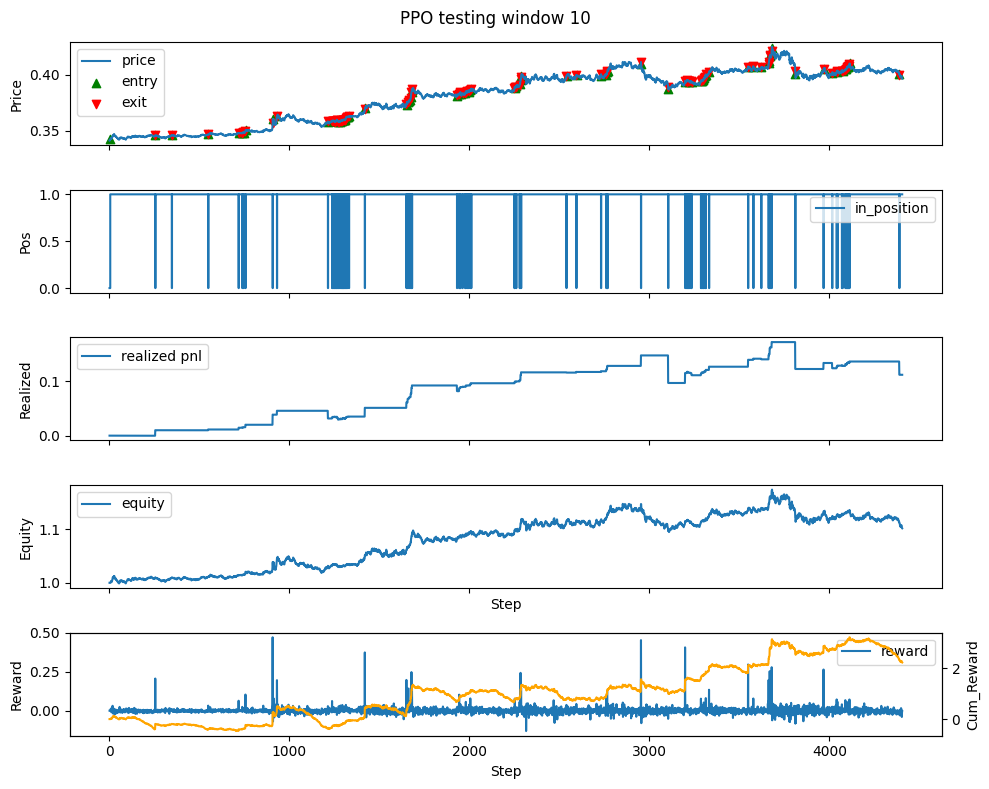


Metrics Report (window 10)
Annual Return: 12.1749
Average Win/Loss Ratio: 0.5415
Avg PnL per trade: 0.0014
Calmar Ratio: 197.3206
Closed trades: 108.0000
Equity: 0.1020
Maximum Drawdown: 0.0617
Profit Factor: 1.8953
Realized PnL: 0.1117
Recovery Factor: 1.6530
Sharpe Ratio: 11.9828
Sortino Ratio: 16.4129
Time Under Water: 0.9732
Value at Risk: 0.0021
Win Rate: 77.7778


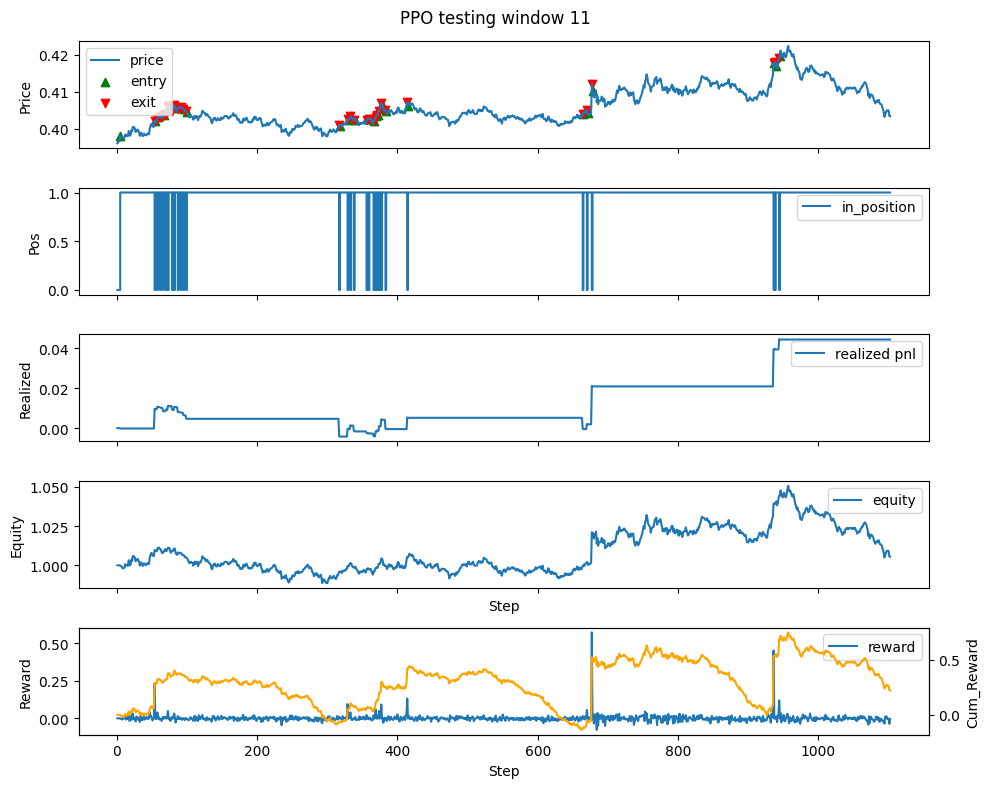


Metrics Report (window 11)
Annual Return: 2.6147
Average Win/Loss Ratio: 1.8605
Avg PnL per trade: 0.0018
Calmar Ratio: 60.0997
Closed trades: 31.0000
Equity: 0.0055
Maximum Drawdown: 0.0435
Profit Factor: 2.9458
Realized PnL: 0.0443
Recovery Factor: 0.1259
Sharpe Ratio: 2.5300
Sortino Ratio: 4.1040
Time Under Water: 0.9728
Value at Risk: 0.0020
Win Rate: 61.2903

Aggregated metrics:
Closed trades: 703.0000
Realized PnL: 0.6808


In [6]:
# @title Test simulation
ACTOR_WEIGHTS = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_results/soft_labels_exp1/actor_best_ep:26_pnl:1.7087.weights.h5"
SL_MODEL_CONFIG = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/soft_labels_exp1/config.joblib"
CONFIG = joblib.load(SL_MODEL_CONFIG)

START = "2024-01-20"
END = "2025-09-23"
TEST_FROM = "2025-08-01"

# Загружаем параметры из сохраненного конфига
PPO_SEQ_LEN = CONFIG['seq_len']
PPO_FEATURES_DIM = len(CONFIG['features']) + len(CONFIG['state'])
PPO_UNITS = CONFIG['units']
PPO_DROPOUT = CONFIG['dropout']
PPO_NUM_ACTIONS = CONFIG['num_actions']
FEATURES = CONFIG['features']

dataframe = df.loc[START:END].copy()

_,_,ppo_test_df, _ = prepare_datasets(dataframe,
                                  FEATURES,
                                  test_from=TEST_FROM,
                                  norm_kind='minmax')

TEST_CFG = EnvConfig(
    mode=1,                         # работаем только от длинной позиции
    fee=0.0005,                     # комиссия
    spread=0.0,                     # без спреда
    leverage=1.0,                   # без плеча
    max_steps=1e9,
    reward_scale=10.0,              # без масштабирования вознаграждения
    valid_time=120,                 # задержка после которой начинат начисляться штраф
    time_penalty=0.00005,           # штраф за бездействие (np.sqrt(max(0, wait_steps -5) * time_penalty))
    hold_penalty=0.00005,           # штраф за удержание (np.sqrt(max(0, hold_steps -5) * hold_penalty))
    terminal_reward = True,         # дополнительная награда по закрытию сделки
    terminal_reward_coef = 2.0,     # коэффициент доп. награды
    close_deal_if_done = True,     # закрытие сделки в конце эпизода
    only_positive_tr_reward = True  # только положительная терминальная награда
)

testing_simulation(
    ppo_test_df,
    ACTOR_WEIGHTS,
    PPO_SEQ_LEN,
    PPO_FEATURES_DIM,
    PPO_UNITS,
    PPO_DROPOUT,
    PPO_NUM_ACTIONS,
    FEATURES,
    TEST_CFG,
    debug=False,
    log_to_pdf=True,
    index_ranges=segments,
)